In [2]:
from simulacion import Simulacion
from estrategia import Estrategia
import parametros_simulacion as ps
import random
from threading import Thread
from abrir_json import Archivos as ar
random.seed(ps.SEED)
from copy import deepcopy
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [6]:
class Analisis:
    def __init__(self, resultados_estrategias, diccionario_resultados_diarios):
        self.resultados_estrategias = resultados_estrategias
        self.diccionario_resultados_diarios = diccionario_resultados_diarios
        self.intervalo_confianza = {}
        self.promedios = {}
        self.desviaciones = {}
        self.analizar()
    
    def analizar(self):
        
        for estrategia in self.resultados_estrategias.keys():
            diccionario_auxiliar = {}
            for kpi in self.resultados_estrategias[estrategia].keys():
                n_keys = 0
                if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                    diccionario_auxiliar[kpi] = list(self.resultados_estrategias[estrategia][kpi].values())
                    n_keys = 1
                elif kpi == "Costos muertos" or kpi == "Costos traslados":
                    diccionario_auxiliar[kpi] = {hospital : [] for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 2
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            diccionario_auxiliar[kpi][hospital].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital])
                elif kpi == "Costos derivaciones":
                    diccionario_auxiliar[kpi] = {hospital : [] for hospital in ["H_1", "H_2", "H_3","WL"]}
                    n_keys = 2
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            diccionario_auxiliar[kpi][hospital].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital])
                elif kpi == "Derivaciones":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : [] for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3","WL"]}
                    n_keys = 3
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                diccionario_auxiliar[kpi][hospital][grupo_diagnostico].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico])
                elif kpi == "Pacientes esperando":
                    diccionario_auxiliar[kpi] = {hospital : {unidad : [] for unidad in ["ICU","SDU_WARD","OR", "GA"]} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 3
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                diccionario_auxiliar[kpi][hospital][grupo_diagnostico].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico])
                elif kpi == "Tasas ocupación":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : {unidad : [] for unidad in ["ICU","SDU_WARD","OR"]} for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 4
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                for unidad in self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico].keys():
                                    diccionario_auxiliar[kpi][hospital][grupo_diagnostico][unidad].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico][unidad])
                elif kpi == "Tiempo de espera pacientes":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : {unidad : [] for unidad in ["ICU","SDU_WARD","OR", "GA"]} for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 4
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                for unidad in self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico].keys():
                                    diccionario_auxiliar[kpi][hospital][grupo_diagnostico][unidad].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico][unidad])
            intervalo_confianza = self.calcular_intervalo_confianza(diccionario_auxiliar)
            promedios = self.calcular_promedios(diccionario_auxiliar)
            desviaciones = self.calcular_desviaciones(diccionario_auxiliar)
            self.intervalo_confianza[estrategia] = intervalo_confianza
            self.promedios[estrategia] = promedios
            self.desviaciones[estrategia] = desviaciones

    def calcular_intervalo_confianza(self, diccionario):
        diccionario_intervalos = {}
        alfa = 0.95
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_intervalos[kpi] = st.norm.interval(alfa, loc = np.mean(diccionario[kpi]), scale = st.sem(diccionario[kpi]))
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_intervalos[kpi] = {hospital : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital]), scale = st.sem(diccionario[kpi][hospital])) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico])) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_intervalos[kpi] = {hospital : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][unidad]), scale = st.sem(diccionario[kpi][hospital][unidad])) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico][unidad])) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico][unidad])) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_intervalos

    def calcular_promedios(self, diccionario):
        diccionario_promedios = {}
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_promedios[kpi] = np.mean(diccionario[kpi])
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_promedios[kpi] = {hospital : np.mean(diccionario[kpi][hospital]) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : np.mean(diccionario[kpi][hospital][grupo_diagnostico]) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_promedios[kpi] = {hospital : {unidad : np.mean(diccionario[kpi][hospital][unidad]) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : {unidad : np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : {unidad : np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_promedios



    def calcular_desviaciones(self, diccionario):
        diccionario_desviaciones = {}
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_desviaciones[kpi] = np.std(diccionario[kpi])
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_desviaciones[kpi] = {hospital : np.std(diccionario[kpi][hospital]) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : np.std(diccionario[kpi][hospital][grupo_diagnostico]) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_desviaciones[kpi] = {hospital : {unidad : np.std(diccionario[kpi][hospital][unidad]) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : {unidad : np.std(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : {unidad : np.std(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_desviaciones



    def grafico_lineas_tiempo(self):
        
        valores_WL_1 = list(self.espera_WL_diaria['Estrategia 1'].values())
        valores_derivaciones_1 = list(self.derivaciones_diarias['Estrategia 1'].values())
        valores_costos_muertos_1 = list(self.costos_muertos_diarios['Estrategia 1'].values())

        valores_WL_2 = list(self.espera_WL_diaria['Estrategia 2'].values())
        valores_derivaciones_2 = list(self.derivaciones_diarias['Estrategia 2'].values())
        valores_costos_muertos_2 = list(self.costos_muertos_diarios['Estrategia 2'].values())

        prom_movil_WL_1 = []
        prom_movil_WL_2 = []
        prom_movil_der_1 = []
        prom_movil_der_2 = []
        prom_movil_cm_1 = []
        prom_movil_cm_2 = []
        
        i = 0

        while i <= 499:
            if i == 0:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i:i+15]))
            elif i > 0 and i + 15 < 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:i+15]))
            elif i + 15 > 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:500]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:500]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:500]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:500]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:500]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:500]))

            i += 15
        
        x = []
        for i in range(len(prom_movil_cm_1)):
            x.append(i)
        
        plt.plot(x, prom_movil_der_1, label = 'Estrategia Base')
        plt.plot(x, prom_movil_der_2, label = 'Estrategia Implementada')
        plt.axvline(10, color = "red", linewidth = 1, linestyle = "dashed", label = 'Día transciente')
        plt.xlabel('Horizonte de tiempo [Quincenas]')
        plt.ylabel('Pacientes derivados por día')
        plt.title('Promedio móvil de derivación a sistema privado')
        plt.legend()
        plt.show()
        
        


            
    def graficos_barras(self):

        n = 1
        x = np.arange(n)
        width = 0.25

        dic = self.promedio_costos_espera_WL['Estrategia 1']
        dic2 = self.promedio_costos_espera_WL['Estrategia 2']
        # conf_interval1_1 = 1.96 * (dic2['Estrategia 1']['ICU'] / np.sqrt(100))
        # conf_interval1_2 = 1.96 * (dic2['Estrategia 1']['OR'] / np.sqrt(100))
        # conf_interval1_3 = 1.96 * (dic2['Estrategia 1']['SDU_WARD'] / np.sqrt(100))
        # conf_interval2_1 = 1.96 * (dic2['Estrategia 2']['ICU'] / np.sqrt(100))
        # conf_interval2_2 = 1.96 * (dic2['Estrategia 2']['OR'] / np.sqrt(100))
        # conf_interval2_3 = 1.96 * (dic2['Estrategia 2']['SDU_WARD'] / np.sqrt(100))
        
        
        # valores_base = [dic['Estrategia 1']['ICU'] , dic['Estrategia 1']['OR'], dic['Estrategia 1']['SDU_WARD']]
        # valores_impl = [dic['Estrategia 2']['ICU'] , dic['Estrategia 2']['OR'], dic['Estrategia 2']['SDU_WARD']]
        plt.bar(x - width / 2, 10, width=width, label='Estrategia base')
        plt.bar(x + width / 2, 1, width=width, label='Estrategia implementada')
        plt.ylabel('Costos en UF')
        plt.yticks([1,2,3,4,5,6,7,8,9,10], ['< 200', '5000', '10000', '15000', '20000', '25000', '30000', '35000', '40000', '> 45000'])
        plt.xticks(x, ['Costos riesgo'])
        plt.title('Costos por factor de riesgo diarios promedio')
        plt.legend(loc='best')
        plt.show()
    

       

       

    def graficos_intervalos(self):
        
        x = 'Desviación'

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

        y1 = self.promedio_costos_derivaciones['Estrategia 1']
        y2 = self.promedio_costos_derivaciones['Estrategia 2']
    
        std1 = self.desviacion_costos_derivaciones['Estrategia 1']
        std2 = self.desviacion_costos_derivaciones['Estrategia 2']

        coef_intervalo_1 = 1.96 * (std1 / np.sqrt(100))
        coef_intervalo_2 = 1.96 * (std2 / np.sqrt(100))
        ax1.bar(x, y1, width = 0.2)
        ax2.bar(x, y2, width = 0.2)
        ax1.errorbar(x, y1, yerr = coef_intervalo_1,fmt='none', ecolor='red', capsize=3)
        ax2.errorbar(x, y2, yerr = coef_intervalo_2, fmt='none', ecolor='red', capsize=3)
        plt.tight_layout()
        plt.show()
        


    def chequear_intervalo(self):
        valores_WL_inicial = list(self.estrategia_inicial.costos_espera_WL_simulacion.values())
        valores_costos_muertos_inicial = list(self.estrategia_inicial.costos_muertos_hospitales_simulacion.values())
        valores_derivaciones_inicial = list(self.estrategia_inicial.costos_derivacion_simulacion.values())

        
        for valor in valores_WL_inicial:
            if self.intervalo_confianza_espera_WL[0] > valor or self.intervalo_confianza_espera_WL[1] < valor:
                self.condicion_WL = False

        for valor in valores_costos_muertos_inicial:
            if self.intervalo_confianza_costos_muertos[0] > valor or self.intervalo_confianza_costos_muertos[1] < valor:
                self.condicion_costos_muertos = False

        for valor in valores_derivaciones_inicial:
            if self.intervalo_confianza_derivaciones[0] > valor or self.intervalo_confianza_derivaciones[1] < valor:
                self.condicion_derivaciones = False

    def intervalo_diferencias(self, variable, estrategia1, estrategia2):
        diferencias = []
        valores_est_1 = list(self.resultados_estrategias[variable][estrategia1].values())
        valores_est_2 = list(self.resultados_estrategias[variable][estrategia2].values())

        for i in range(len(valores_est_1)):
            dif = valores_est_1[i] - valores_est_2[i]
            diferencias.append(dif)
        
        print(diferencias)

        intervalo = st.norm.interval(confidence = 0.95, loc = np.mean(diferencias), scale = st.sem(diferencias))
        print(intervalo)
        return intervalo

    def media_desviacion_intervalos_confianza_derivaciones(self):
        der_est_1 = list(self.derivaciones_diarias['Estrategia 1'].values())[149:]
        der_est_2 = list(self.derivaciones_diarias['Estrategia 2'].values())[149:]

        mean_est_1 = np.mean(der_est_1)
        std_est_1 = np.std(der_est_1)
        int_conf_1 = st.norm.interval(confidence = 0.95, loc = mean_est_1, scale = std_est_1)

        mean_est_2 = np.mean(der_est_2)
        std_est_2 = np.std(der_est_2)
        int_conf_2 = st.norm.interval(confidence = 0.95, loc = mean_est_2, scale = std_est_2)

        self.info_derivaciones['Estrategia 1'] = {'Promedio': mean_est_1, 'Desviacion Estándar': std_est_1, 'Intervalo de confianza': int_conf_1}
        self.info_derivaciones['Estrategia 2'] = {'Promedio': mean_est_2, 'Desviacion Estándar': std_est_2, 'Intervalo de confianza': int_conf_2}




In [11]:
resultados_estra = ar('None')
diccionario = resultados_estra.leer_resultados('resultados_mejores_estrategias.json')
#diccionario_diario = ar('None').leer_resultados('resultados_diarios_estrategias.json')
analisis = Analisis(diccionario, {})

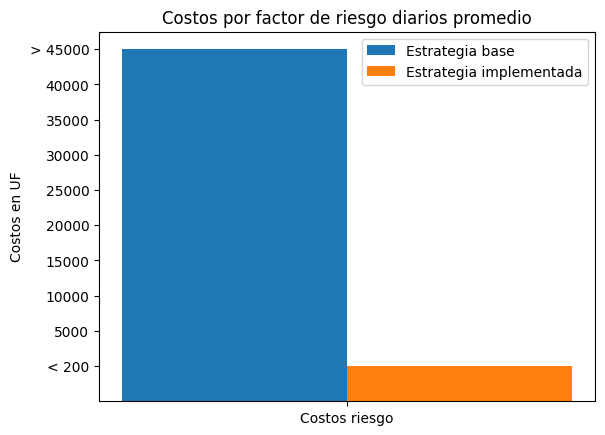

In [125]:
analisis.graficos_barras()

In [70]:
analisis.promedio_costos_derivaciones

{'Estrategia 1': 5850.95753509382,
 'Estrategia 2': 5931.838047013987,
 'Estrategia 3': 6012.368115875582}

In [71]:
analisis.intervalo_confianza_tasas_ocupacion

{'Estrategia 1': {'ED': (4.613711649257327, 4.843361521474391),
  'GA': (nan, nan),
  'ICU': (68.79986868557641, 69.35193131442357),
  'OR': (30.789587178761042, 31.45263504346121),
  'SDU_WARD': (89.84834023796135, 89.96537404775289)},
 'Estrategia 2': {'ED': (1.6708039979120795, 1.8540740508684075),
  'GA': (79.01805994921577, 79.67860671745086),
  'ICU': (71.0747384336108, 71.5512615663892),
  'OR': (30.066569125523017, 30.654541985588125),
  'SDU_WARD': (88.45452607935543, 88.57424943084855)},
 'Estrategia 3': {'ED': (1.767534728310451, 1.9424652716895472),
  'GA': (79.06920693343876, 79.7532930665612),
  'ICU': (71.06328345525917, 71.67331654474081),
  'OR': (29.958007235786603, 30.52088165310233),
  'SDU_WARD': (88.49463126397275, 88.63598098092514)}}

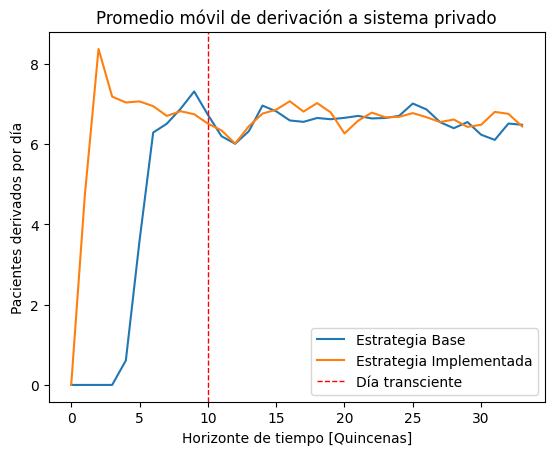

In [93]:
analisis.grafico_lineas_tiempo()

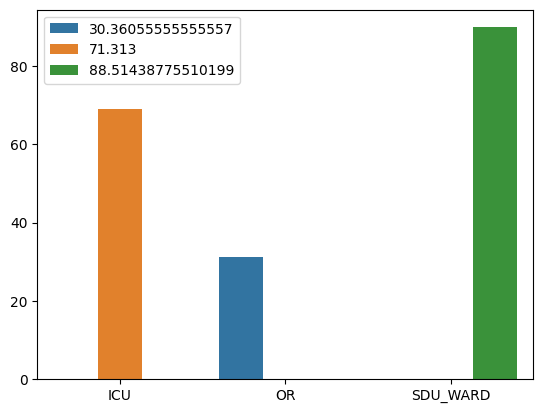

In [24]:
analisis.graficos_intervalos()

In [12]:
analisis.promedios

{'Estrategia 0': {'Costos jornada': 37956.971708639256,
  'Costos muertos': {'H_1': 306.75742018534953,
   'H_2': 360.25329092746716,
   'H_3': 431.5609295830266},
  'Costos derivaciones': {'H_1': 1941.8695147673134,
   'H_2': 1321.3890685647027,
   'H_3': 654.1604063147339,
   'WL': 2073.6946002923037},
  'Costos espera WL': 30856.857632549796,
  'Costos traslados': {'H_1': 4.081468520473353,
   'H_2': 3.7321452047710157,
   'H_3': 2.6152317293166347},
  'Derivaciones': {'H_1': {'1': 0.5633333333333334,
    '2': 0.30666666666666664,
    '3': 0.39999999999999997,
    '4': 0.21666666666666665,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'H_2': {'1': 0.12333333333333334,
    '2': 0.43333333333333335,
    '3': 0.26666666666666666,
    '4': 0.18666666666666668,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'H_3': {'1': 0.16,
    '2': 0.04,
    '3': 0.25666666666666665,
    '4': 0.14,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'WL': {'1': 0.0,


In [106]:
analisis.derivaciones_diarias

{'Estrategia 1': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: 0.0,
  20: 0.0,
  21: 0.0,
  22: 0.0,
  23: 0.0,
  24: 0.0,
  25: 0.0,
  26: 0.0,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: 0.0,
  35: 0.0,
  36: 0.0,
  37: 0.0,
  38: 0.0,
  39: 0.0,
  40: 0.0,
  41: 0.0,
  42: 0.0,
  43: 0.0,
  44: 0.0,
  45: 0.0,
  46: 0.0,
  47: 0.0,
  48: 0.0,
  49: 0.0,
  50: 0.0,
  51: 0.0,
  52: 0.0,
  53: 0.0,
  54: 0.0,
  55: 0.0,
  56: 0.0,
  57: 0.0,
  58: 0.0,
  59: 0.0,
  60: 0.15,
  61: 0.25,
  62: 0.6,
  63: 0.65,
  64: 0.35,
  65: 1.1,
  66: 1.25,
  67: 1.5,
  68: 0.85,
  69: 0.55,
  70: 1.55,
  71: 1.7,
  72: 1.6,
  73: 3.05,
  74: 3.2,
  75: 3.0,
  76: 4.15,
  77: 5.75,
  78: 7.15,
  79: 5.25,
  80: 5.25,
  81: 5.25,
  82: 6.0,
  83: 6.75,
  84: 5.75,
  85: 5.35,
  86: 7.3,
  87: 7.9,
  88: 7.

In [115]:
analisis.media_desviacion_intervalos_confianza_derivaciones()

In [11]:
analisis.intervalo_diferencias('Funcion objetivo', 'Estrategia 2', 'Estrategia 3')

[-9.025345840388582, 1221.5235358998852, -218.54344352674434, 496.47843849282344, -510.9987606161967, -57.760303977564945, -130.24086671492478, -525.5216944802132, -449.69030113440476, -216.72498650641137, -54.24742744750165, -740.5350636759704, 333.1823987428743, -111.7115931402841, -60.175408554978276, -379.0967751720309, 23.445131137521457, -123.92517582989876, -51.97594594799102, -1087.6368581250672, 19.543151876423508, -238.31095912813998, 229.8760774329303, -681.9587337637167, -379.08594550434464, 618.8639969028272, -153.10304069388985, -485.7945582988359, 329.38882616702176, -982.6219815693876, -505.46801087343374, -7.859250453626373, -526.9601029935666, -387.31107018185503, -242.7018441424434, 313.28338191703733, 649.9026610847841, 214.75775416602391, -393.72478006945585, -763.4502882168963, -422.70506501187083, 299.2156540563019, -19.368644131241126, -772.3198500281414, -308.17918271787585, 904.2410582302637, -857.868465562864, 85.01413922774645, -218.65619261224037, 324.89268

(-190.15406010199573, -6.515110405980437)

In [9]:
analisis.promedio_costos_diarios

{'Estrategia 1': 56977.993334321014,
 'Estrategia 2': 6226.124227924456,
 'Estrategia 3': 6324.458813178444}